# Práctica 5
## Prototipo de sistema que identifica la matrícula de un vehículo y obtiene sus caracteres a partir de un reconocedor de texto
<ul>
<li>Nikhil Chandru Durgadas Chellaram</li>
<li>Raúl Mateus Sánchez</li>
</ul>

Para comprobar el desarrollo de la práctica: https://github.com/raulmat19/Vision-por-Computador/tree/main/Practica-5

#Paquetes necesarios

In [ ]:
import cv2
import pytesseract
import glob
import os
import matplotlib.pyplot as plt
import shutil

Para el desarrollo de esta práctica, primero debemos situar el contexto de la misma. Una línea de desarrollo de esta práctica era la de emplear _YOLOv7_ como detector de vehículos, y a partir de las detecciones generadas, extraer mediante técnicas como el uso de contornos la matrícula del vehículo, si fuese posible, para procesarla de cara a que el reconocedor de texto _Tesseract_ se focalice en las zonas de probable presencia de la matrícula.

Nosotros hemos apostado por otra línea de desarrollo que puede ser fácilmente adaptada a cualquier entorno además de mantenida y actualizada. El trabajo realizado consiste en entrenar el detector _YOLOv7_ mediante un dataset creado por nosotros, configurando los parámetros pertinentes para conseguir una serie de resultados más que positivos, visualizables en [training-results](training-results/results.png) así como más detalles como la ejecución del entrenamiento en el fichero [results.txt](training-results/results.txt) y en las gráficas de la misma carpeta.

Nuestra motivación, además de contar con una GPU "tocha" para entrenar, ha sido buscar una manera de identificar matrículas aprovechando las capacidades del detector YOLOv7 al máximo y no solo para detectar vehículos, haciendo más fácil la tarea (aunque bien complicado a la hora de entrenar).

Para crear el dataset, dentro del tiempo ajustado que hemos tenido para la tarea de recopilación de imágenes, hemos empleado hasta 82 imágenes, la mayoría propias. Posteriormente, mediante la herramienta _Roboflow_, hemos subido las imágenes y realizado el _labelling_ gracias a las facilidades de esta herramienta. A continuación, _Roboflow_ permite aumentar el tamaño del dataset hasta 3 veces el número de imágenes en el plan gratuito mediante opciones como introducir imágenes del dataset en blanco y negro, con saturación, invertidas, etc. En nuestro caso, hemos aplicado las siguientes:

![dataset-details](dataset-details.png)

[Dataset en Roboflow](https://universe.roboflow.com/licenseplates-h9qfr/spanish-license-plates)<br></br>
Para acceso al mismo, contactar con nosotros (Roboflow no permite dar acceso sin un email)

Creado el dataset, queda descargarlo y ubicar las carpetas que genera (train, test y valid) dentro de la carpeta del _YOLOv7_, así como el fichero data.yaml dentro de /data. Ya solo quedaría ejecutar el comando para entrenar: 

<code>python train.py --device 0 --weights yolopt7.pt --cfg cfg/training/yolov7.yaml --data data: data/license-plate-data.yaml --hyp data/hyp.scratch.custom.yaml --workers 8 --batch-size 8 --epochs 500 --name yolov7-license-plates</code>

Para poder emplear la GPU, el comando en el GitHub de la práctica no funciona. En cambio, el siguiente sí funciona:

<code>conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia</code>

Una vez entrenado el detector con unos resultados aceptables (en nuestro caso, llevó más de tres intentos, aunque gracias a la GPU no se tardaba tanto), obtenemos un archivo con los mejores pesos (_weights_), el cual emplearemos a partir de ahora para detectar matrículas, llamado yolov7-license-plates.pt, el cual se encuentra en este repositorio

A partir de aquí, añadimos al repo imágenes que no se hayan usado para entrenar al detector (para no hacer trampa) y se modifica el detector, en su fichero detect.py, para que guarde como imagen las distintas detecciones en la carpeta (licenses-plates-detected) y posteriormente sean tratadas para que el reconocedor de texto pueda sacar la matrícula. El fichero detect.py también se incluye en el repositorio, cuya idea modificación proviene de: https://github.com/RizwanMunawar/yolov7-object-cropping/blob/main/detect_and_crop.py

In [16]:
from IPython.display import Video
from base64 import b64encode

shutil.rmtree('runs/', ignore_errors=True)
!python detect.py --weights yolov7-license-plates.pt --conf 0.5 --source videos\test_license_plates.mp4  --device 0

list_of_files = glob.glob('runs\detect\*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
latest_file += "\\*"
list_of_files = glob.glob(latest_file) # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

compress_path = "videos/detected/" + os.path.basename(latest_file)
cap = cv2.VideoCapture(latest_file)
 
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(compress_path,fourcc, 5, (640,480))
 
while True:
    ret, frame = cap.read()
    if ret == True:
        b = cv2.resize(frame,(640,480),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        out.write(b)
    else:
        break
    
cap.release()
out.release()
cv2.destroyAllWindows()

Namespace(weights=['yolov7-license-plates.pt'], source='videos\\test_license_plates.mp4', img_size=640, conf_thres=0.5, iou_thres=0.45, device='0', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

video 1/1 (1/465) d:\GII\Cuarto\Vision-por-Computador\Practicas-Repo\Vision-por-Computador\Practica-5\videos\test_license_plates.mp4: 3 License-Plates, Done. (11.0ms) Inference, (5.0ms) NMS
video 1/1 (2/465) d:\GII\Cuarto\Vision-por-Computador\Practicas-Repo\Vision-por-Computador\Practica-5\videos\test_license_plates.mp4: 3 License-Plates, Done. (12.0ms) Inference, (1.0ms) NMS
video 1/1 (3/465) d:\GII\Cuarto\Vision-por-Computador\Practicas-Repo\Vision-por-Compu

YOLOR  v0.1-115-g072f76c torch 1.13.0 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191.5MB)

c:\Users\rauln\anaconda3\envs\yolov7\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS


In [17]:
cap = cv2.VideoCapture(compress_path)
while True:
    ret, frame = cap.read()
    if ret == True:
        cv2.imshow("video", frame)
    
    # Detenemos pulsado ESC
    if cv2.waitKey(20) == 27:
        break
    
cap.release()
cv2.destroyAllWindows()

A continuación, se define la ruta a Tesseract, se borran varios directorios para ahorrar almacenamiento y se comienza con la detección de las imágenes ubicadas en la carpeta /images/

En caso de que la ejecución del comando falle, sería conveniente sustituir el detect.py de este repo por el ubicado en la carpeta local donde se encuentre instalado YOLOv7, en nuestro caso, es la misma carpeta que la del environment. Con el fichero yolov7-license-plates.pt, solo haría falta ponerlo ahí. Otra opción es simplemente, ejecutar el tercer comando, el segundo comentado, para evitar problemas.

In [3]:
# Si la ruta de Tesseract no está en el PATH, ruta al ejecutable
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

# Lenguajes disponibles
print(pytesseract.get_languages(config=''))
shutil.rmtree('runs/', ignore_errors=True)
shutil.rmtree('licenses-plates-detected', ignore_errors=True)

#Aplica reconocedor a imagen cargada
#print(pytesseract.image_to_string(img_rgb))

!python detect.py --weights yolov7-license-plates.pt --conf 0.75 --source images\ --save-txt --device 0

## En caso de no tener GPU o no poder usarla
# !python detect.py --weights yolov7-license-plates.pt --conf 0.75 --source images\ --save-txt --device cpu

## En caso de que de problemas ambos comandos
## La ruta es orientativa, debería ser la ruta donde cada uno tenga instalado YOLOv7
# !python C:/Users/<usuario>/anaconda3/envs/yolov7 detect.py --weights yolov7-license-plates.pt --conf 0.75 --source images\ --save-txt --device cpu

['eng', 'equ', 'osd', 'spa', 'spa_old']
Namespace(weights=['yolov7-license-plates.pt'], source='images\\', img_size=640, conf_thres=0.75, iou_thres=0.45, device='0', view_img=False, save_txt=True, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

1 License-Plate, Done. (11.1ms) Inference, (3.0ms) NMS
 The image with the result is saved in: runs\detect\exp\2465DYD.jpg
1 License-Plate, Done. (11.1ms) Inference, (1.0ms) NMS
 The image with the result is saved in: runs\detect\exp\2522LNH.jpg
1 License-Plate, Done. (12.1ms) Inference, (1.0ms) NMS
 The image with the result is saved in: runs\detect\exp\4597HXL.jpg
1 License-Plate, Done. (11.6ms) Inference, (1.0ms) NMS
 The image with the resu

YOLOR  v0.1-115-g072f76c torch 1.13.0 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191.5MB)

c:\Users\rauln\anaconda3\envs\yolov7\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS


Una vez que el detector entrenado devuelva las respectivas matrículas, se procede a tratar dichas imágenes.

En primer lugar, se crea un bucle que vaya recorriendo las imágenes de las matriculas. Dentro del mismo, se debe procesar la imagen de la mejor forma posible para que el Tesseract funcione de la manera más óptima, esto se consigue realizando una reducción de ruido de la imagen con el uso de la función <strong>cv2.blur()</strong>. 

Posteriormente, se pasa la imagen con poco ruido al formato Canny para facilitar la detección de bordes de las matrículas y ya finalmente se pasa por el Tesseract con la opción de configuración --psm 10 porque al probar todas las opciones de este parámetro, el que mejores resultados ha dado con diferencia ha sido este, por ello se ha decidido seleccionar dicha opción.

E2465 DYD



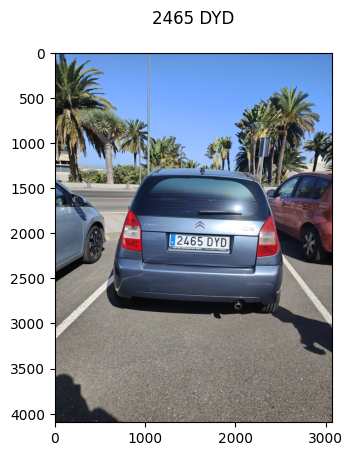

42522 LNH



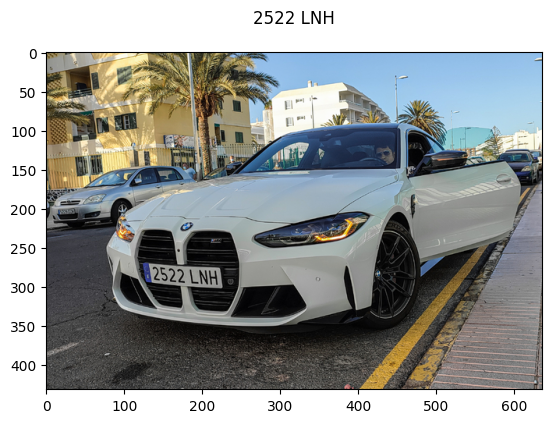

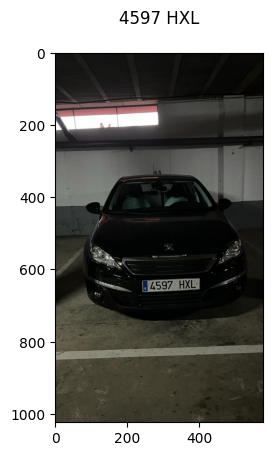

84841 LFS|



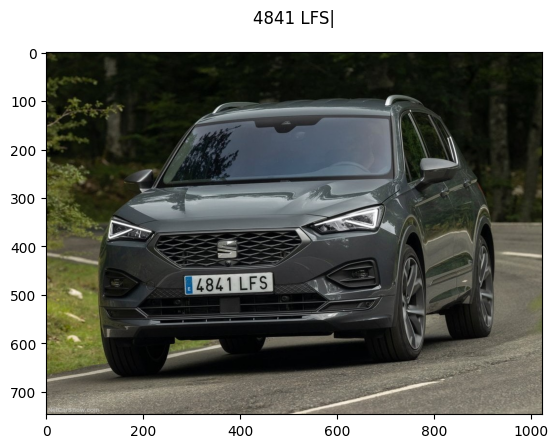

#8168 GIG



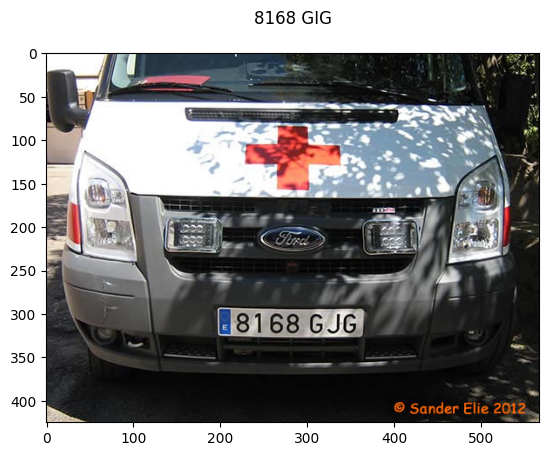

£8712 HJG



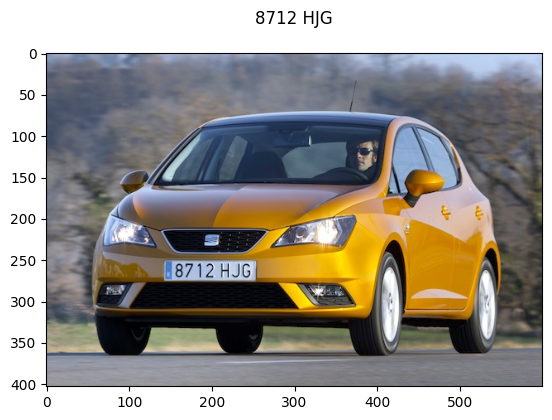

18878 LWB



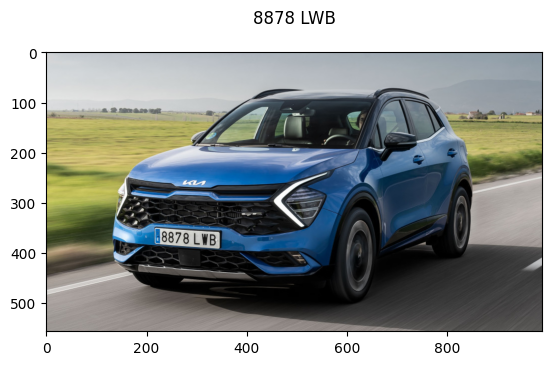

In [31]:
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'
lista_coches = os.listdir('images')
lista_matriculas = os.listdir('licenses-plates-detected')
matricula = ""

for i in range(len(lista_coches)):
    car_img = cv2.imread("images/"+lista_coches[i])
    car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
    img = cv2.imread("licenses-plates-detected/"+lista_matriculas[i])
    img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_sin_ruido = cv2.blur(img_gris,(3,3), 0)
    canny = cv2.Canny(img_sin_ruido,100,200)
    #canny = cv2.dilate(canny,None,iterations=1)
    
    matricula = pytesseract.image_to_string(img_gris,config='--psm 10')
    if len(matricula) > 9:
        print(matricula)
        matricula = matricula[1:]
    if len(matricula) < 3:
        matricula = "No se ha podido detectar la matricula"

    plt.imshow(car_img)
    plt.title(matricula)
    plt.show()